In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anime-recommendation-database-2020/watching_status.csv
/kaggle/input/anime-recommendation-database-2020/rating_complete.csv
/kaggle/input/anime-recommendation-database-2020/animelist.csv
/kaggle/input/anime-recommendation-database-2020/anime.csv
/kaggle/input/anime-recommendation-database-2020/anime_with_synopsis.csv
/kaggle/input/anime-recommendation-database-2020/html folder/instructions.txt
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/reviews_1.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/staff.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/reviews_2.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/pictures.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/stats.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/details.html
/kaggle/input/anime-recommendation-database-2020/html folder/html/5/reviews_3.html
/kaggle/input/anime

# Recommendation Systems 
Recommendation systems are widely used today especially in the E-commerce and the Entertainment industry. It not only allows for better marketing strategies but also creates a **win-win situation** as dedicated customers and audience want to view products that are similar to their likes. People also dont want to stay updated with current trends and dont want to miss out on them. Therefore they appreciate poular recommendations.


## Collborative Filtering


![](https://miro.medium.com/max/1064/1*mz9tzP1LjPBhmiWXeHyQkQ.png)

- As you can see in the picture above , there are a few limitations with the content based filtering.
- To make up for these limitations, the Collaborative Filtering Algorithm not only uses the similarities between products but also the similarities between users by analysing user behaviour to recommend similar products.

Therefore We will be dividing our work into 3 different tasks:
- **Task 1:** Find out similar anime 
- **Task 2:** Find out similar users
- **Task 3:** Make recommendations for a random user

## 1. Dependencies Required 

In [2]:
!pip install keras

     |████████████████████████████████| 1.7 MB 2.1 MB/s 


In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import  keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from wordcloud import WordCloud
from collections import defaultdict
from IPython.display import FileLink

2022-09-20 01:12:37.822624: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-20 01:12:37.822777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 2. Loading the Dataset and Initial Preprocessing 

In [4]:
#Loading the datasets 
anime_df = pd.read_csv('../input/anime-recommendation-database-2020/anime.csv')
synopsis_df = pd.read_csv('../input/anime-recommendation-database-2020/anime_with_synopsis.csv')
rating_df = pd.read_csv('../input/anime-recommendation-database-2020/rating_complete.csv', low_memory=False)

In [5]:
anime_df.shape , synopsis_df.shape , rating_df.shape

((17562, 35), (16214, 5), (57633278, 3))

#### Too many rows in the ratings so lets make it so that the user must have rated atleast 200 animes

In [6]:
rating_df.columns

Index(['user_id', 'anime_id', 'rating'], dtype='object')

In [7]:
ratings = rating_df['user_id'].value_counts()
rating_df=rating_df[rating_df['user_id'].isin(ratings[ratings >= 200].index)].copy()


In [8]:
len(rating_df)

41320341

### 2.1 Removing Duplicates

In [9]:
dups=rating_df.duplicated()

if dups.sum()>0:
    print(f"{dups.sum()} duplicates ")
    rating_df=rating_df[~dups]

print(f"{rating_df.duplicated().sum()} duplicates")
    

0 duplicates


### 2.2 Scaling the ratings between (0-1.0)
This is recommended for a better performance of the model.

In [10]:
scaler = MinMaxScaler()
rating_df['rating']=scaler.fit_transform(rating_df['rating'].values.reshape(-1,1))

In [11]:
Avgrating = np.mean(rating_df['rating'])
print('Avg is :' , Avgrating)

Avg is : 0.7071209578367798


In [12]:
u_rating = rating_df.groupby('user_id')['rating'].count() #Tells us how many ratings each user has given
top_users = u_rating.dropna().sort_values(ascending=False)[:20] # gives us top 20 users with most ratings
top_ratings = rating_df.join(top_users, rsuffix='_r' , how='inner',on='user_id') # defining the rating_df with the top 20 users

u_anime = rating_df.groupby('anime_id')['rating'].count() #gives us a list of animes with their number of ratings
most_ratings = u_anime.dropna().sort_values(ascending=False)[:20] # top 20
top_ratings= top_ratings.join(most_ratings, rsuffix = '_r',how='inner' , on='anime_id')
top_ratings.dropna()
top_ratings.pivot_table(index='user_id' ,columns='anime_id',values='rating',aggfunc=np.sum)

anime_id,1535,1575,2904,4224,5081,5114,6547,8074,9253,10620,11757,15809,16498,19815,20507,22319,30276,31240,31964,32281
user_id,,,,,,,,,,,,,,,,,,,,
10255,0.777778,0.777778,0.888889,0.777778,0.555556,1.000000,0.666667,0.222222,1.000000,0.555556,NaN,0.666667,0.777778,0.444444,0.555556,NaN,0.333333,0.333333,0.444444,0.555556
64807,0.666667,1.000000,1.000000,0.666667,1.000000,0.888889,0.666667,0.888889,0.444444,0.444444,0.000000,0.555556,0.777778,0.777778,0.777778,0.222222,0.888889,0.333333,0.777778,1.000000
68042,1.000000,0.888889,0.777778,0.888889,1.000000,0.888889,0.666667,0.222222,0.888889,0.333333,0.333333,0.555556,0.888889,0.222222,0.111111,0.444444,0.888889,0.777778,0.777778,0.888889
85106,0.888889,0.888889,1.000000,0.888889,0.888889,1.000000,0.777778,0.555556,1.000000,0.666667,0.555556,0.777778,1.000000,0.888889,0.666667,0.333333,1.000000,0.777778,0.777778,1.000000
122341,0.222222,0.111111,0.111111,0.222222,0.222222,0.777778,0.444444,0.000000,0.666667,0.111111,0.000000,0.222222,0.000000,0.333333,0.333333,0.111111,0.555556,0.000000,0.222222,0.111111
162615,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
182280,0.888889,0.777778,0.555556,NaN,0.777778,1.000000,0.666667,0.666667,1.000000,NaN,NaN,0.777778,NaN,NaN,NaN,NaN,NaN,NaN,0.555556,0.777778
189037,0.888889,0.666667,0.666667,0.888889,0.666667,0.777778,1.000000,0.666667,1.000000,0.777778,0.666667,0.888889,0.555556,0.666667,0.666667,0.666667,0.777778,0.777778,0.666667,0.666667
190748,0.555556,0.222222,0.222222,0.333333,0.444444,0.777778,0.666667,0.222222,0.555556,0.333333,0.000000,0.555556,0.555556,0.222222,0.111111,NaN,0.222222,NaN,NaN,NaN


I think the null values here states that some of the top users have not rated some of the top animes.

In [13]:
user_ids = rating_df["user_id"].unique().tolist() #listing unique users
user2_encoded = {x: i for i, x in enumerate(user_ids)} # numbering each user
encoded2_user = {i: x for i, x in enumerate(user_ids)} # assigning the user to the number
rating_df["user"] = rating_df["user_id"].map(user2_encoded) # substituing the user values



#Similarly for the anime
anime_ids = rating_df['anime_id'].unique().tolist()
anime2_encoded = {x: i for i, x in enumerate(anime_ids)}
encoded2_anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2_encoded)


In [14]:
#Total number of users and anime
n_users=len(user2_encoded)
n_anime=len(anime2_encoded)
n_users , n_anime

(95143, 16864)

In [15]:
rating_df.head(10)

,user_id,anime_id,rating,user,anime
189,3,25835,0.777778,0,0
190,3,28171,0.777778,0,1
191,3,32282,0.777778,0,2
192,3,35788,0.888889,0,3
193,3,9253,0.888889,0,4
194,3,5958,0.777778,0,5
195,3,8407,0.777778,0,6
196,3,2418,0.777778,0,7
197,3,29786,0.666667,0,8
198,3,18277,0.666667,0,9


As you can see, instead of random numbers now we have organised our dataset

### 2.3 Seperating the Features and Label and splitting dataset into Train and Test sets

In [16]:
x= rating_df[['anime','user']].values
y= rating_df['rating']

In [17]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,stratify=y ,random_state=42)

In [18]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((37188306, 2), (4132035, 2), (37188306,), (4132035,))

In [19]:
# Defining input containing both the user and anime data as inputs
x_train_array = [x_train[:, 0], x_train[:, 1]]
x_test_array = [x_test[:, 0], x_test[:, 1]]

In [20]:
x_train_array

[array([2499,  365, 5306, ..., 4051, 1567, 5083]),
 array([81426, 50611, 52620, ..., 69403, 87002,  1440])]

In [21]:
# Intializing the TPU Accelerator 
import tensorflow as tf

TPU_INIT = True

tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
print(tf.__version__)

2022-09-20 01:14:38.543610: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-20 01:14:38.552516: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-20 01:14:38.552600: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 01:14:38.552679: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (870c0c818f4d): /proc/driver/nvidia/version does not exist
2022-09-20 01:14:38.559900: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

2.4.1


## 3.  Model Building

In [22]:
#Defining the layers for the model. We embed both users and animes in to 128-dimensional vectors.

def Recommender():
    embedding_size= 128 #output dimensions
    
    #Defining the layer where we take user data as input 
    user = Input(name='user', shape =[1])
    user_embedding = Embedding(name='user_embedding',
                              input_dim = n_users,
                              output_dim = embedding_size)(user)
    
    #Defining the layer where we take anime data as input
    anime = Input(name='anime',shape =[1])
    anime_embedding = Embedding(name='anime_embedding',
                                input_dim = n_anime,
                                output_dim = embedding_size)(anime)
    
    #Defining the layer to produce a dot product of the anime and user vectors
    x_layer = Dot(name ='Dot_Layer',normalize = True, axes=2)([user_embedding,anime_embedding])
    
    #Flattening the layer to convert it into a 1-D array 
    x_layer =Flatten()(x_layer)
    
    #Dense layer - Hidden nn layer. Initializers define the way to set the initial random weights of Keras layers.
    x_layer = Dense(1, kernel_initializer='he_normal')(x_layer)
    
    #Batch Normalization to make sure features are scaled
    x_layer = BatchNormalization()(x_layer)
    
    #Defnining the activation function. Using th Sigmoid function
    x_layer = Activation('sigmoid')(x_layer)
    
    model = Model(inputs = [user,anime],outputs = x_layer )
    model.compile(loss ='binary_crossentropy', metrics=['mae','mse'], optimizer='Adam')
    
    return model


if TPU_INIT:    
    with tpu_strategy.scope():
        model = Recommender()
else:
    model = Recommender()

model.summary()
    
    
    
    
    
    
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
anime (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 128)       12178304    user[0][0]                       
__________________________________________________________________________________________________
anime_embedding (Embedding)     (None, 1, 128)       2158592     anime[0][0]                      
______________________________________________________________________________________________

In [23]:
# Defining callbacks : Callbacks help us prevent overfitting, visualize our training progress, save checkpoints

#Learning Rate
start_lr = 0.00001 
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

# defining a function for the LearningrateScheduler that allows us to control the learning rate between epochs
# def lr_function(epoch):
#     if epoch < rampup_epochs:
#         return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
#     elif epoch < rampup_epochs + sustain_epochs:
#         return max_lr
#     else: (max_lr - start_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
# lr_callback = LearningRateScheduler(lambda epoch: lr_function(epoch),verbose=0)    

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 90
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lr_callback = LearningRateScheduler(lr_scheduler,verbose=1) 

#defining the output path where the model will store the saved checkpoints
checkpoint_filepath = './weights.h5'

#defining the checkpoint function , we do this to save the weights for further use later
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   save_best_only=True 
                                  )

#Earlystopping function allows us to stop the model once the model performance stops showing any improvements
early_stopping= EarlyStopping(patience=3,monitor='val_loss',mode='min',restore_best_weights=True)


my_callbacks = [
               model_checkpoint,
               lr_callback,
               early_stopping
               ]

### 3.1 Model Training

In [24]:
#Now we train the model using the data and the functions defined above
history = model.fit(x_train_array,
                    y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test_array,y_test),
                    callbacks = my_callbacks
                   )

model.load_weights(checkpoint_filepath)

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
465/465 [==============================] - 27s 40ms/step - loss: 0.6927 - mae: 0.2214 - mse: 0.0720 - val_loss: 0.6138 - val_mae: 0.1630 - val_mse: 0.0402
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
465/465 [==============================] - 13s 27ms/step - loss: 0.6058 - mae: 0.1534 - mse: 0.0368 - val_loss: 0.5907 - val_mae: 0.1359 - val_mse: 0.0301
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
465/465 [==============================] - 13s 27ms/step - loss: 0.5853 - mae: 0.1288 - mse: 0.0279 - val_loss: 0.5835 - val_mae: 0.1252 - val_mse: 0.0271
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
465/465 [==============================] - 13s 27ms/step - loss: 0.5810 - mae: 0.1224 - mse: 0.0261 - val_loss: 0.5828 - val_mae: 0.1243 - val_mse: 0.0

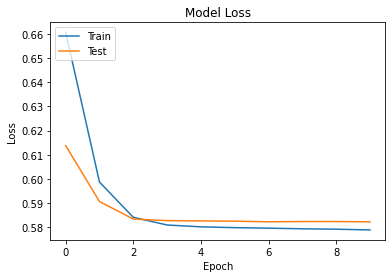

In [25]:
#Training results 
plt.plot(history.history["loss"][:-3])
plt.plot(history.history["val_loss"][:-3])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'] , loc='upper left')
plt.show()

### 3.2 Extracting Weights from the Model

In [26]:
def extract(name,model):
    weight_layer = model.get_layer(name) #name of the layer
    weights = weight_layer.get_weights()[0] #the weight values
    weights = weights / np.linalg.norm(weights,axis =1).reshape((-1,1)) #normalizing weights
    return weights

user_weights = extract('user_embedding' , model)
anime_weights = extract('anime_embedding' , model)

    

# 4. Task 1: Finding Similar Animes (Recommendations Based on Similar Content)


In [27]:
anime_df.sample(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
16489,41061,Heya Camp△: Sauna to Gohan to Sanrin Bike,7.44,"Slice of Life, Comedy",Unknown,へやキャン△「サウナとごはんと三輪バイク」,Special,1,"May 27, 2020",Unknown,...,291.0,411.0,1160.0,1402.0,468.0,149.0,29.0,10.0,5.0,10.0
13003,35347,Kemono Friends: Bus-teki,6.63,"Comedy, Fantasy",Unknown,けものフレンズ 12.1話「ばすてき」,ONA,1,"Apr 4, 2017",Unknown,...,139.0,93.0,250.0,515.0,440.0,250.0,52.0,30.0,27.0,26.0


In [28]:
#removing unknowns 
anime_df = anime_df.replace("Unknown",np.nan )

In [29]:
#Redefining the anime dataframe with proper names and removing null values

def getName(anime_id): 
    try:
        name=anime_df[anime_df.anime_id == anime_id].eng_name.values[0] #Extracting the English name
        if name is np.nan:
            name = anime_df[anime_df.anime_id == anime_id].Name.values[0] #Extracting the name if english value is null
    
    except Exception as e:
        print(e)
        
    return name 

#Renaming some columns
anime_df['anime_id']=anime_df['MAL_ID'] 
anime_df['eng_name']=anime_df['English name']
anime_df['eng_name']=anime_df.anime_id.apply(lambda x:getName(x))

#sorting values by highest score
anime_df.sort_values(by=['Score'],
                    inplace=True,
                    ascending=False,
                    kind='quicksort',
                    na_position='last')

anime_df=anime_df[["anime_id", "eng_name", 
         "Score", "Genres", "Episodes", 
         "Type", "Premiered", "Members"]]


In [30]:
anime_df.head(10)

,anime_id,eng_name,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121
6474,11061,Hunter x Hunter,9.1,"Action, Adventure, Fantasy, Shounen, Super Power",148,TV,Fall 2011,1673924
6006,9969,Gintama Season 2,9.08,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",51,TV,Spring 2011,365579
741,820,Legend of the Galactic Heroes,9.07,"Military, Sci-Fi, Space, Drama",110,OVA,NaN,230168
7261,15417,Gintama:Enchousen,9.04,"Action, Comedy, Historical, Parody, Samurai, S...",13,TV,Fall 2012,222819
9886,28851,A Silent Voice,9.0,"Drama, School, Shounen",1,Movie,NaN,1387607


In [31]:
# This function will be giving us the the names of the recommended animes 
def getAnimeFrame(anime):
    if isinstance(anime ,int):
        return anime_df[anime_df.anime_id == anime]
    if isinstance(anime,str):
        return anime_df[anime_df.eng_name == anime]
    
    

In [32]:
synopsis_df.drop('Score',axis=1 ,inplace=True)

In [33]:
synopsis_df.sample(2)
#[Note: Synopsis is spelled as sypnopsis]

,MAL_ID,Name,Genres,sypnopsis
4217,7062,Hidamari Sketch x ☆☆☆,"Slice of Life, Comedy, School, Seinen",The continuing stories of the daily life of th...
11874,35407,Rhythm,Dementia,comfortable rhythm composed of light and shado...


In [34]:
#Extracting the synopsis values
def getSynopsis(anime):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [35]:
pd.set_option("max_colwidth", None)

#Defining a Function that returns us a detailed dataframe of the recommendationsusing the model weights

def similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name).anime_id.values[0] #Extracting the original id of anime
        encoded_index = anime2_encoded.get(index) #Extracting the reset encoded index 
        weights = anime_weights # defining the weights from the model

        dists = np.dot(weights, weights[encoded_index]) #dot product of the weights and the index
        sorted_dists = np.argsort(dists) # returning the sorted indices

        n = n + 1            

        if neg:
                closest = sorted_dists[:n] # Neg closeness
        else:
                closest = sorted_dists[-n:] # Pos closeness
        print(f'The animes closest to {name} are:')

        if return_dist:
            return dists, closest

        rindex = anime_df

        SimilarityArr = [] #empty array that will contain all the similar animes based on closest distance

        for close in closest:
            decoded_id = encoded2_anime.get(close)
            sypnopsis = getSynopsis(decoded_id)
            anime_frame = getAnimeFrame(decoded_id)

            anime_name = anime_frame.eng_name.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                      "similarity": similarity,"genre": genre,
                                      'synopsis': sypnopsis})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id!= index].drop(['anime_id'],axis=1)

    except:
        print(f'{name}!, Not Found in Anime list')

## 4.1 Testing out the model

In [36]:
similar_animes('Dragon Ball Z', n=2 )

The animes closest to Dragon Ball Z are:


,name,similarity,genre,synopsis
1,Kaede New Town,0.579372,"Comedy, Romance, School, Slice of Life","kio Osawa, an average 5th grade school boy, lives in the suburbs of Osaka. Mikio likes Haruko Tezuka, a cute little girl in his class. However, Mikio is too shy and withdrawn to tell Haruko that he likes her. One day, Mikio's close friend Megane brings news that Haruko is about to move away to another town... Kaede Newtown is a romantic comedy animation created by Naoto Iwakiri, an Osaka-born illustrator. With cute little characters and music created by Japanese band Aprils and singer-songwriter TOMOVSKY, Kaede Newtown takes you back to the good ol' town you lived in during the good ol' days of your childhood. (Source: crunchyroll.com)"
0,Bishoujo Senshi Sailor Moon Eternal Movie 1,0.578143,"Demons, Magic, Romance, Shoujo",Bishoujo Senshi Sailor Moon Eternal serves as the fourth installment in Toei Animation's reboot of Naoko Takeuchi's original magical girl manga. The sequel was announced in January 2017 as a part of the franchise's 25th anniversary and later confirmed to be a two-part anime film covering the Dream arc. (Source: MAL News)


In [37]:
similar_animes('Naruto', n=10 )

The animes closest to Naruto are:


,name,similarity,genre,synopsis
9,Harmagedon,0.680684,"Action, Adventure, Comedy, Drama, Mecha, Sci-Fi, Shounen","From the depths of space he is coming... Ancient beyond understanding, his power is immeasurable. He has destroyed half the universe and is on his way here. He is... Genma. Only two people are aware of the imminent catastrophe: Princess Luna, a modern day prophetess and Vega, a cybernetic crusader from a world long since ravaged by Genma. Determined to spare the Earth from a similar fate, Luna and Vega must try to mobilize the most potent psychics in the world. Together, this army of fledging psychic warriors must succeed where billions have tried... and failed. But will they be able to gather their champions in time? Genma's agents are already on Earth to ensure that their master meets with no opposition! (Source: AnimeNfo)"
8,Loups=Garous,0.664796,"Sci-Fi, Mystery, Thriller","In a future governed through the lens of a camera, where people eat synthetic food and pursue an online existence in lieu of physical contact, a group of children begin meeting up in the real world. The aloof Ayumi Kono, the genius hacker Mio Tsuzuki, and the socially awkward Hazuki Makino set out to find the fourth member of their group, Yuko Yabe, who has gone missing. With the help of Myao Rei, an unregistered citizen proficient in martial arts, they are able to find Yuko. However, when their situation takes a sudden turn for the worse, the group stumbles headlong into a dark mystery that challenges everything they know about their world."
7,Noobow: Kieta Medal,0.648221,"Kids, Slice of Life",No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
6,Skip Beat!,0.646599,"Comedy, Drama, Romance, Shoujo","Bright, diligent, and yet naïve 16-year-old Kyouko Mogami works hard to support the career and dreams of her childhood friend, crush, and rising pop icon, Shoutarou Fuwa. Toiling endlessly at burger joints and tea ceremonies, the innocent Kyouko remains unaware that day in day out, all her tireless efforts have been taken for granted, until, one day, she finds out that her beloved Shou sees her as nothing but a free servant. Shocked, heartbroken and enraged, she vows to take revenge on the rookie star by entering the ruthless world of entertainment herself. As she steps into this new life, Kyouko will face new challenges as well as people who will push her out of her comfort zone. Based on the best-selling shoujo manga by Yoshiki Nakamura, Skip Beat showcases the growth of a young woman who slowly unlearns how to work herself to the bone for the satisfaction of others and takes her future into her own hands instead."
5,Bakusou Kyoudai Let's & Go!! WGP Bousou Mini Yonku Daitsuiseki,0.638667,"Adventure, Cars, Shounen, Sports","on gets tricked into installing a chip into his racing car called ""Gun Bluster"" by the mini-4wd company he was associated with. His car starts racing without control and causing various riots with fellow racers, Rion teams up with the TRF Victorys and start chasing after Gun Bluster to remove the chip. Rion, Retsu and Go Seiba along with the other TRF members, Ryo Takaba with the help of his little brother, Jiromaru, Tokichi and J are confroted with an association that is also after Gun Bluster, but what are their intentions? United along-side their trademark mini-4wd, the TRF's and Rion race together and avoid traps to safelly capture Gun Bluster!"
4,The☆Doraemons: The Mysterious Thief Dorapan The Mysterious Cartel,0.629065,"Kids, Fantasy, Comedy, Sci-Fi, Shounen",The mysterious thief Dorapin sets up a scheme with the intent of stealing the Friendship Telecards from the Doraemons. (Source: ANN)
3,Pokemon:Pokemon Ranger and the Temple of the Sea,0.627014,"Action, Adventure, Kids, Drama, Fantasy","Satoshi and his friends get lost in an unknown wasteland. They eventually come across a ""Water Pokemon Show"" performed by the star of the Mariner Troupe, Hiromi. Hiromi is 

   ![](https://c.tenor.com/aLUOlVX7OOoAAAAd/naruto.gif)

In [38]:
similar_animes('Blue Spring Ride')

The animes closest to Blue Spring Ride are:
Blue Spring Ride!, Not Found in Anime list


![](https://c.tenor.com/nZaCMM6r1a4AAAAd/love-katie.gif)

In [39]:
similar_animes('One Piece')

The animes closest to One Piece are:


,name,similarity,genre,synopsis
9,Ryuusei Sentai Musumet,0.578776,"Adventure, Comedy, Ecchi, Romance, Sci-Fi","One day, seven shooting stars fell on to the ground. The shooting stars were colored by seven colors, and they had terrible powers. Those who took the shooting star were tuned into monsters by embodying their desires. Dr. Mishina and Dr. Kishiwada obtained the red, green, and blue stars secretly, and they studied the stars. Finally, they could successfully control their power by putting a special helmet on. The newly developed helmet, ""Musumet"", was as large as an automobile helmet. Putting Musumet on the head, it turned a person's body into the strongest one on the earth. Furthermore, it received the signal from the brain and amplified the inherent power and ability unlimitedly. To utilize the power of ""Musumet"", to keep the world peace, and to protect from the disasters caused by the remaining shooting stars, Dr. Mishima and Dr. Kishida founded a secret organization ""MET"". However, he died before he accomplished his aim. The bereaved daughters, Aoi, Midori, and Kurenai, made up their minds to become Musmet in order to execute the father's will. Even if they turned into Musumet, their wearing wouldn't change except helmets, gloves, and boots. Therefore, they had to go to the scenes wearing their own clothes. The girls had to go to the incident spots occasionally wearing school uniforms, occasionally gymnasium suits, occasionally swimming suits, depending the case, they had to go there even if they were naked, and they would do great jobs. On the other hand, at other times, they were ordinal adolescent girls who were dreaming of lovely meetings with boyfriends. Whether would they cope with the world peace and boyfriends at the same time? (Source: AnimeNfo)"
8,Time Bokan Series: Zenderman,0.562757,"Action, Sci-Fi, Adventure, Comedy, Super Power, Mecha","Dr Monja is a scientist who is curious about the nature of the legendary Elixir of Life which grants the drink eternal lifetimes and forever youth. He built a device called the ""Time Tunnel"" in order to let a team of youngsters to start a quest down the timeline and various spaces to find an exact answer. A trio of villains, however, is also seemingly after the exact same thing. (Source: Wikipedia)"
7,Bannertail:The Story of Gray Squirrel,0.550906,"Kids, Drama","Soon after birth a young squirrel comesc to a farm, and gets caught by a human. This human then tries to find him to their pet cat. However, the cat feels sorry for the squirrel and adopts him as their child and names the squirrel Banner. Banner and the cat live happily in the farm, but their happy lives don't last long. A fire destoys the farm, and Banner gets separated from his mother the cat. (Source: ANN)"
6,Bakumatsu Gijinden Roman,0.547545,"Historical, Fantasy","The stage is the close of the Edo period, an age when, not unlike our own time, both natural and man-made disasters left chaos in their wake. Manjiro makes a living helping the people of the troubled capital city, but behind the scenes, he also works in secret to take back precious belongings stolen from the people by unjust political powers and conspiratorial menaces. The people call him ""Get-backer Roman."" (Source: Crunchyroll)"
5,The☆Doraemons: The Mysterious Thief Dorapan The Mysterious Cartel,0.546762,"Kids, Fantasy, Comedy, Sci-Fi, Shounen",The mysterious thief Dorapin sets up a scheme with the intent of stealing the Friendship Telecards from the Doraemons. (Source: ANN)
4,Shouka Robo Zeres: Fire Dragon wo Taose!,0.545900,"Kids, Mecha, Sci-Fi","fire safety anime with a sci-fi mecha flare. When an ocarina is blown, the mecha Zeres arrives to extinguish the flames."
3,Koro Sensei Quest!,0.544845,"Comedy, Magic, Shounen","One day, class 3-E of Kunugigaoka Magic School receives a special mission: to kill their homeroom teacher, the Demon King Koro-sensei. To increase their chances of succeeding, the class searches for the three most pow

# 5. Task 2: Finding Similar Users (Recommendations Based on Similar Users)

In [40]:
#Picking out a random user
ratings_per_user = rating_df.groupby('user_id').size()
random_user = ratings_per_user[ratings_per_user < 500].sample(1,random_state=0).index[0]
print(f"user_id = {random_user}")

user_id = 265647


In [41]:
#Defining a function to find similar users 
pd.set_option("max_colwidth", None)

def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2_encoded.get(index)
        weights = user_weights
    
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print(f' users similar to #{item_input}')

        if return_dist:
            return dists, closest
        
        rindex = anime_df
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = encoded2_user.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        
        return Frame
    
    except:
        print(f'{item_input}!, Not Found in User list')

In [42]:
similar_users = find_similar_users(int(random_user), 
                                   n=5)

#Finding users who have a similarity score of more than 0.3 excluding themselves
similar_users = similar_users[similar_users.similarity > 0.3]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users.head()

 users similar to #265647


,similar_users,similarity
4,217242,0.387678
3,197355,0.373422
2,333555,0.367683
1,346938,0.359349
0,4892,0.352042


## 5.1 Understanding User Preferences

In [43]:
#Defining a function to visualize genres 
def show_wordcloud(all_genres):
    genre_cloud=WordCloud(width=800,
                          height=400,
                          colormap='tab20c'
                          ).generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8)) 
    plt.imshow(genre_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

#Defining a function t0 get fav genre of users
def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False) #dropping null values
        all_genres = defaultdict(int) #default dic as to get a default value for non defined items 
        
        #Most of the shows have multiple genres. We seperate them and store them in the empty list
        genres_list = [] 
        for genres in frame['Genres']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1  #removing empty spaces  
        if plot:
            show_wordcloud(all_genres) #Visualizing
        
        return genres_list


In [44]:
#defining a function to generate fav animes and genres of a random user
def get_user_pref(user_id, plot=False, Verbose=0 ):
    animes_watched = rating_df[rating_df.user_id == user_id] #animes watched by the user_id in input
    user_rating_percentile = np.percentile(animes_watched.rating,75)
    #returns rating greater than the 75th percentile
    animes_watched = animes_watched[animes_watched.rating >= user_rating_percentile]
    #extracting the anime ids rated highly by the user
    top_animes = animes_watched.sort_values(by=['rating'],ascending=False).anime_id.values 
    
    #creating a dataframe that returns the anime name and the genres
    pref_df = anime_df[anime_df['anime_id'].isin(top_animes)]
    pref_df = pref_df[['eng_name','Genres']]
    
    if Verbose!=0:
        print(f"> User #{user_id} has rated {len(animes_watched)} shows, with an average rating of {animes_watched['rating'].mean()}")
    
    if plot:
        print("Preferred Genres are:")
        getFavGenre(pref_df, plot)
    
    return pref_df

> User #265647 has rated 95 shows, with an average rating of 0.9099415204678347
Preferred Genres are:


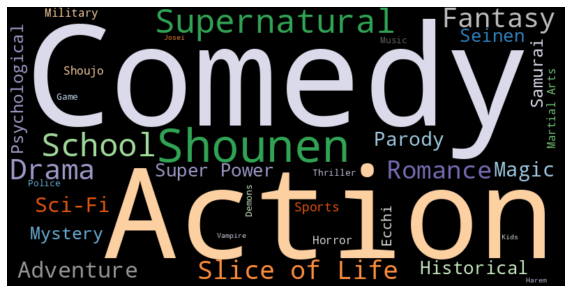

Anime this user has highly rated :


,eng_name,Genres
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
9886,A Silent Voice,"Drama, School, Shounen"
12242,Gintama Season 5,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
11308,Your Name.,"Romance, Supernatural, School, Drama"
833,Gintama,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
11624,Haikyu!! 3rd Season,"Comedy, Sports, Drama, School, Shounen"
14293,Gintama.:Silver Soul Arc - Second Half War,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"


In [45]:
user_pref= get_user_pref(random_user,plot=True,Verbose = 1)
print("Anime this user has highly rated :")

pd.DataFrame(user_pref).head(20)

# 6. Task 3: Recommending Animes to a Random User

In [46]:
def get_recommended_animes(similar_users,n=10):
    
    recommended_animes=[]
    anime_list=[]
    
    for user_id  in similar_users.similar_users.values:
        pref_list= get_user_pref(int(user_id),Verbose=0)
        pref_list= pref_list[~ pref_list.eng_name.isin(user_pref.eng_name.values)] #removing users own preferences
        anime_list.append(pref_list.eng_name.values)

    anime_list=pd.DataFrame(anime_list)    
    sorted_list=pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(10)


    for i,anime_name in enumerate(sorted_list.index):    
        n_user_pref=sorted_list[sorted_list.index == anime_name].values[0][0]
        if isinstance (anime_name,str):
            try:
                frame = getAnimeFrame(anime_name)
                anime_id = frame.anime_id.values[0]
                genre = frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id))
                recommended_animes.append({'n':n_user_pref,
                                           'anime_name':anime_name,
                                           'Genres':genre,
                                          'synopsis':synopsis})
            except:
                pass
    recommended_df=pd.DataFrame(recommended_animes) 
    return recommended_df
        
        

## 6.1 Recommendations for our defined random user based on CF

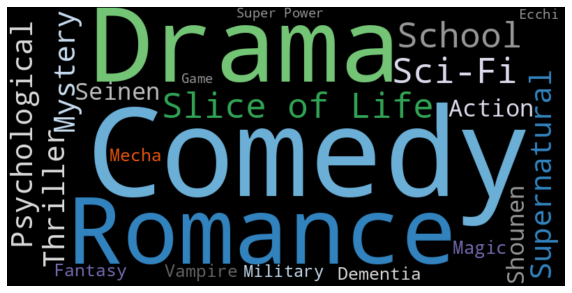

 Top recommendations for user: 265647


,n,anime_name,Genres,synopsis
0,4,My Teen Romantic Comedy SNAFU TOO!,"Slice of Life, Comedy, Drama, Romance, School","Yahari Ore no Seishun Love Comedy wa Machigatteiru. Zoku picks up immediately after the events of the first season, continuing the adventures of the Volunteer Service Club—the dispassionate Hachiman Hikigaya, the cheerful Yui Yuigahama, and the competitive Yukino Yukinoshita—as it dedicates itself to helping any student with issues that they may face. With the rift among his own group widening, Hachiman begins to realize that his knack for quickly getting to the root of other people's troubles is a double-edged sword: sometimes the best solution is not necessarily the most appropriate one."
1,4,Puella Magi Madoka Magica,"Psychological, Drama, Magic, Thriller","adoka Kaname and Sayaka Miki are regular middle school girls with regular lives, but all that changes when they encounter Kyuubey, a cat-like magical familiar, and Homura Akemi, the new transfer student. Kyuubey offers them a proposition: he will grant any one of their wishes and in exchange, they will each become a magical girl, gaining enough power to fulfill their dreams. However, Homura Akemi, a magical girl herself, urges them not to accept the offer, stating that everything is not what it seems. A story of hope, despair, and friendship, Mahou Shoujo Madoka★Magica deals with the difficulties of being a magical girl and the price one has to pay to make a dream come true."
2,4,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
3,4,Bakemonogatari,"Romance, Supernatural, Mystery, Vampire","Koyomi Araragi, a third-year high school student, manages to survive a vampire attack with the help of Meme Oshino, a strange man residing in an abandoned building. Though being saved from vampirism and now a human again, several side effects such as superhuman healing abilities and enhanced vision still remain. Regardless, Araragi tries to live the life of a normal student, with the help of his friend and the class president, Tsubasa Hanekawa. When fellow classmate Hitagi Senjougahara falls down the stairs and is caught by Araragi, the boy realizes that the girl is unnaturally weightless. Despite Senjougahara's protests, Araragi insists he help her, deciding to enlist the aid of Oshino, the very man who had once helped him with his own predicament. Through several tales involving demons and gods, Bakemonogatari follows Araragi as he attempts to help those who suffer from supernatural maladies."
4,4,Neon Genesis Evangelion,"Action, Sci-Fi, Dementia, Psychological, Drama, Mecha","In the year 2015, the world stands on the brink of destruction. Humanity's last hope lies in the hands of Nerv, a special agency under the United Nations, and their Evangelions, giant machines capable of defeating the Angels who herald Earth's ruin. Gendou Ikari, head of 

In [47]:
recommended_animes = get_recommended_animes(similar_users, n=10)
getFavGenre(recommended_animes, plot=True)

print(f' Top recommendations for user: {random_user}')
recommended_animes

## 7. Recommendations based on Predicted Rankings
Now we Try to list the Top 10 animes recommended to the user based on predicted ratings.


In [48]:
def Predicted_rankings_recommender(random_user):
    print(f"Showing recommendations for user {random_user}")

    animes_watched_by_user = rating_df[rating_df.user_id == random_user]
    anime_not_watched_df = anime_df[~anime_df["anime_id"].isin(animes_watched_by_user.anime_id.values)]

    #returning list of anime not watched that also exists in the encoded index 
    #Focus is on the not watched list, as we need to recommend new anime that the user has not watched
    anime_not_watched = list(
        set(anime_not_watched_df['anime_id']).intersection(set(anime2_encoded.keys()))
    )
    anime_not_watched = [[anime2_encoded.get(x)] for x in anime_not_watched]

    user_encoder = user2_encoded.get(random_user) #returns the encoded index

    #creating a numpy array by stacking the encoded user_id and the number of animes not watched by them
    #[Note: hstack stacks input arrays horizontally(column wise)]
    user_anime_array = np.hstack(
        ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
    )

    user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]] #seperating the arrays

    pred_ratings = model.predict(user_anime_array).flatten() #returns predicted ratings for animes not watched

    top_ratings_indices = (-pred_ratings).argsort()[:10] #Here (-) gives us the indices of the top 10 ratings as by default argsort sorts in ascending  

    #extracting the top rated encoded id's of the animes not watched
    recommended_anime_ids = [encoded2_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices]

    Results = []
    top_rated_ids = []

    for index, anime_id in enumerate(anime_not_watched):
        rating = pred_ratings[index] #gives us ratings of all the animes not watched
        id_ = encoded2_anime.get(anime_id[0]) #gives us the encoded id of all the animes not watched
        if id_ in recommended_anime_ids:
            try:
                top_rated_ids.append(id_)
                condition = (anime_df.anime_id == id_)  
                name = anime_df[condition]['eng_name'].values[0]
                genre = anime_df[condition].Genres.values[0]
#                 score = anime_df[condition].Score.values[0]  (showing nan values)
                synopsis = getSynopsis(int(id_))        
            except:
                continue

            Results.append({"name": name, 
                            "predicted_rating": rating,
                            "genre": genre, 
                            'sypnopsis': synopsis})

    print(" Top 10 anime recommendations for you are: ")
    Top10_df = pd.DataFrame(Results).sort_values(by='predicted_rating', ascending=False)
    
    return Top10_df

In [49]:
Predicted_rankings_recommender(random_user)

Showing recommendations for user 265647
 Top 10 anime recommendations for you are: 


,name,predicted_rating,genre,sypnopsis
8,Goman-hiki,0.963467,Kids,Shorts made by Otogi Pro (later remade for TV as Doubutsu Mura no Monogatari).
2,Shuuseki Life,0.962215,Music,usic video directed by Kousuke Sugimoto for the song Shuuseki Life by Handsome Kenya.
1,Crayon Shin-chan Movie 05: Ankoku Tamatama Daitsuiseki,0.959562,"Action, Adventure, Comedy, Seinen","action comedy film depicting the Nohara family who get caught in a fight between two clans, Tamayura and Tamayomi. Set in Tokyo and Aomori (northern end of Japan's main island). The Tamayomi clan had plotted to revive the evil genie Jarke and to conquer the world. To stop Tamayomi's plot, the three gay brothers (Rose, Lavender and Lemon) from Tamayura clan wrested Jarke's ball, which was a key to revive Jarke, from the bar girl gang of Tamayomi clan, but Shinnosuke's younger sister Himawari swallowed down the ball. The Nohara family, with the three gay brothers and a female detective Yone Higashimatsuyama, fights a fierce battle against the Tamayomi gang chasing them. (Source: Manabu Tsuribe)"
5,After School Midnighters,0.958097,"Fantasy, Kids","ako, Miko, and Mutsuko are three young girls visiting St. Claire Elementary, a school filled with strange legends. They have an abrupt encounter with Kunstrijk, a human body anatomy model, and Goth, a skeleton model. Both haunt the soon-to-be-demolished science room. Seeking revenge for being vandalized by the three girls, Kunstrijk invites them to the school's midnight party in order to scare them. Together, the five go on a quest to collect three mythical medals that can grant a wish and hopefully save the science room. (Source: ANN)"
4,Heaven's Lost Property:Forte,0.955288,"Comedy, Ecchi, Harem, Romance, Sci-Fi, Shounen, Supernatural","Sakurai Tomoki has settled into his life with the two angeloids, Ikaros and Nymph, and is enjoying himself immensely. However, he keeps having weird dreams and asks all of his friends to help him investigate the cause. Nymph conjures up a device that enables people, but not angeloids, to enter other people's dreams. The device malfunctions at first but eventually they get to what was supposed to be Tomoki's dream but discover that something is very wrong with it. Later, a meteor comes crashing down from the skies at the site of the large cherry blossom tree where Tomoki first discovered Ikaros. An extremely well endowed blonde angeloid with a huge sword emerges from the meteor and sets off in search of Tomoki!"
3,Black Butler Special,0.954359,"Comedy, Demons, Historical, Shounen, Supernatural","Earl Ciel Phantomhive's Funtom Corporation is sponsoring a charity performance of Hamlet to be shown to a group of poor children as a celebration of its third anniversary. However, when the theater company hired for the stage play is suddenly delayed and won't make it in time for the scheduled performance, the company is faced with a dilemma. With the promise of plenty of press coverage, Ciel must find a way to rectify the situation and commands his butler, Sebastian Michaelis, to ensure the success of the play. But with a haphazard ensemble of amateur actors—including Ciel, his fiancée Elizabeth Midford, his servants, and many others—how can they possibly put on the show in time?"
0,Naruto Narutimate Hero 3: Tsuini Gekitotsu! Jounin vs. Genin!! Musabetsu Dairansen Taikai Kaisai!!,0.953978,"Game, Adventure, Comedy, Shounen","contest is made by the Fifth Hokage called Jonin vs Genin. The point is to collect crystals for points, with the higher-ranked Chunin and Jonin holding crystals worth more points. The Genin have blue crystals, while the Chunin and Jonin have red crystals. The video shows various fights between the Genin and Jonin, which each instance ending in the Jonin unknowingly losing their crystal (or discarding it). (Source: Wikipedia)"
6,"You're Being Summoned, Azazel Z",0.952293,"Comedy, Demons, Supernatural","The second season of Yondemasu yo, Azazel-san."
7,Robotan (1986),0.951438,"Comedy,

In [50]:
#Testing on some other random user
rating_df.groupby('user_id').size()


user_id
3         315
6         311
16        247
17        709
19        679
         ... 
353385    281
353386    234
353392    250
353395    738
353398    759
Length: 95143, dtype: int64

In [51]:
Predicted_rankings_recommender(19)

Showing recommendations for user 19
 Top 10 anime recommendations for you are: 


,name,predicted_rating,genre,sypnopsis
1,Domain of Murder,0.991046,"Drama, Mystery, Psychological, Seinen","One stormy night, a young woman is shot to death on a cliff; her body is found floating in the waters below the next morning. She was last seen with a man who is now being sought not only for her death. Meanwhile, an estranged wife hires Goro, a private investigator, to find her husband. Alongside another member of law enforcement with his own motives for finding the man, Goro sets forth on a trail of tragedy and intrigue to find the reason and connection behind the murders and missing husband. (Source: Anime-Planet; edited)"
6,Smile,0.990545,"Kids, Music",usic video for the song SMILE by ANNA BANANA that was featured on NHK's Minna no Uta program. The video was animated by Seiichi Hayashi.
5,The Rebirth of Buddha,0.989928,"Psychological, Supernatural, Romance","17-year-old Sayako Amanokawa aspires to become a journalist, just like Kanemoto, an elite newspaper writer she looks up to. But Kanemoto, shamed from an erroneous report about a corruption scandal, jumps in front of a train and commits suicide. Since that incident, Sayako suddenly becomes able to see spirits and almost loses her life. However, from that near-fatal incident she experiences something extraordinary. The journalist inside her stirred, she embarks to find out about the truth. But the forces that stand in her way turn out to be much more formidable than she ever imagined. (Source: ANN)"
8,The Legend of Qin,0.989765,"Action, Historical, Martial Arts, Fantasy",The movie reveals the events before Ge Nie and Tianming defeated 300 soldiers at Huangyang Chuan right at the start of season 1. The events will retell how Tianming and Ge Nie met. A new character and her relations to the Western Regions will be introduced as well. (Source: wuxiaedge.com)
2,Choco to Watashi,0.989619,"Kids, Music",Junko Yagami's performance of Choco to Watashi for NHK's Minna no Uta program.
7,Karugamo Oyako no Hi no Youjin,0.989487,"Drama, Kids",ducational fire safety video for kids with an imaginative spin of a fire brigade made of talking ducks.
4,Tong Ling Fei,0.989461,"Comedy, Historical, Drama, Romance","Qian Yunxi, the oldest daughter of the prime minister was born with a special ability. Because of this she was deemed 'abnormal' and was raised at Mt. Lin Yun. Upon turning 16, she took her younger sister's place to marry into the royal family of Ye. Rumors say Ye Youming is strange, cold and cruel. Just how will Qian Yunxi's fate play out? (Source: Baka-Updates Manga)"
3,Tales of Vesperia ~The First Strike~,0.988654,"Action, Adventure, Fantasy, Magic, Military","Ten years after the Great War against the demon-beasts, the empire rules over the world and prosperity relies on the massive use of aer. Yuri Lowell and Flynn Scifo are two young men who have just enrolled the ranks of the prestigious Imperial Knights. One day, they are sent to the town of Ceazontania, where abnormal aer activity has reportedly caused the proliferation of horribly mutated beasts, with serious threat for the whole region. Meanwhile, the Knights Supreme Commander Alexei Denoia and the naive Princess Estellise are involved in a behind-the-curtains struggle for power in the capital. The situation in Ceazontania deteriorates as the garrison of Imperial Knights finds that they cannot expect any immediate support from the capital. Then, Niren Fedrok, commander of the Imperial Knights in Ceazontania, takes an unexpected decision that is going to change Yuri and Flynn's destiny forever. What are the secrets behind the extraordinary events that are happening around Yuri and Flynn? Will they be able to defend the innocent people of Ceazontania and stay true to their beliefs? (Source: Funimation)"
0,Kekkou Kamen,0.988533,"Comedy, Ecchi","he academy Miami Takashi attends, higher education has sunk to the lowest levels of depravity, with armed hall monitors, teachers who wear masks to hide their identities and spec

In [52]:
Predicted_rankings_recommender(random_user=17)

Showing recommendations for user 17
 Top 10 anime recommendations for you are: 


,name,predicted_rating,genre,sypnopsis
8,Gokiburi-chan,0.983625,Kids,"story about love, friendship, and effort that cockroaches and their friends put into living behind a refrigerator in an ordinary salaryman's family home. Cockroaches who are hated by all humans strive every day to be liked by everyone in the family; will the day when they are accepted by the family come?"
6,Osaru no Tairyou,0.983232,Slice of Life,No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
1,Fruits Basket 2nd Season,0.982836,"Slice of Life, Comedy, Supernatural, Drama, Romance, Shoujo","ar has passed since Tooru Honda began living in the Souma residence, and she has since created stronger relationships with its inhabitants Shigure, Kyou, and Yuki. She has also grown closer to the rest of the Souma family and has become familiar with their ancestral secret, having helped them with many of their personal issues. The closer Tooru gets, however, the more she begins to realize that their secret holds a darker truth than she first presumed. Summer is approaching and Tooru is invited to spend her days with the Soumas, mainly Kyou and Yuki. Tooru wishes for an easy-going vacation, but her close relationships with the two boys and the rest of the Soumas may prove to cause trouble. As they grow more intimate, their carefree time together is hindered by older hardships and feelings from the past that begin to resurface. The Eternal Banquet also dawns on the members of the zodiac, and they must tend to their duties alongside the unnerving head of the family, Akito Souma. With the banquet approaching and a plethora of feelings to be solved, will Tooru's life with the Soumas remain peaceful, or will she find herself in a situation from which she cannot escape?"
5,Grand Marche no Meikyuu,0.981634,"Fantasy, Game","The animated opening for Square Enix's Grand Marche no Meikyuu RPG mobile game which launched for Android and iOS on September 8, 2016."
3,Kimi wo Matsu,0.981452,"Drama, Music","usic video for the song Kimi wo Matsu by Aimer that was on her third album ""DAWN"". It was included on DVD with the first press release of the CD. The video was directed by Gaku Kinoshita."
7,Urda,0.980385,"Action, Historical, Military, Sci-Fi","This fictional story took place in Europe around 1943. At that time Nazi secretly plotted a plan called Urda. Two agents, Janet and Erna received a task to investigate and prevent the completion of the secret plan. (Source: AniDB)"
0,Mori no Ongakukai,0.980169,Comedy,"During a concert in the forest, the big bad wolf begins to annoy the other animals with his foul smoking, noisy interruptions and destruction of the grounds. The other animals band together and eject the wolf for poor manners."
2,Soushunfu,0.979507,"Kids, Music",usic video for Shonan Chor Grün's performance of Soushunfu that was featured on NHK's Minna no Uta program. The song was originally written and composed in 1913 by Kazumasa Yoshimaru and Akira Nakata respectively. The video was animated by Seiichi Hayashi.
4,Yuuto-kun ga Iku,0.979341,"Kids, Sports",No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
9,Anne-Happy,0.978240,"Slice of Life, Comedy, School","Tennomifune Academy is an elite institution for the best and the brightest, with the exception of Class 1-7, the so-called ""Happiness Class."" Each member of the classroom copes with personal misfortunes, and the special class is geared to help them move past their issues and find true happiness. After being accepted into the academy, An Hanakoizumi, Ruri Hibarigaoka, and Botan Kumegawa find themselves placed into the Happiness Class, plagued by dreadful luck, love problems, and bad health respectively. Alongside their classmates, they do their best to overcome the difficulties they are faced with in pursuit of a life filled with joy."


# 8. Saving Model
Further plans to use this model to create a Recommendation app and deploy it on Heroku.

In [53]:
model.save('anime_model.h5')
FileLink(r'./anime_model.h5')

/kaggle/working/anime_model.h5